<a href="https://colab.research.google.com/github/LEDazzio01/Simplest-Conformal-Prediction/blob/main/cpb-the-crucial-calibration-set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Conformal Prediction Basics: The Crucial Calibration Set

**Introduction to Conformal Prediction with Synthetic Regression Data**

Hello! This notebook explores how conformal prediction works, using a simple synthetic regression dataset.  Conformal prediction provides a measure of confidence in its predictions, which is crucial in many applications.

We'll walk through the process step-by-step:

1.  Generating synthetic regression data.
2.  Training a simple linear regression model.
3.  Implementing conformal prediction using the calibration set.
4.  Analyzing how the choice of the calibration set affects the validity of our predictions.

By the end of this notebook, you'll understand how conformal prediction can be applied to quantify the uncertainty of a model's predictions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# 1. Generate Sample Data (Regression)
np.random.seed(0)
X = np.sort(5 * np.random.rand(100, 1), axis=0)  # 100 samples, 1 feature
y = np.sin(X).ravel() + np.random.randn(100) * 0.1  # Add some noise
X = X.astype(np.float32)
y = y.astype(np.float32)


Here, we generate a synthetic dataset for a regression problem.  The input feature `X` is a set of 100 points between 0 and 5.  The output `y` is calculated using the sine function, with added random noise to simulate real-world data.  This synthetic data allows us to clearly illustrate the concepts of conformal prediction without the complexities of real-world image data.


In [3]:
# 2. Split Data into Training, Calibration, and Test Sets
X_train, X_cal_test, y_train, y_cal_test = train_test_split(X, y, test_size=0.4, random_state=42) # 40% for calibration and test
X_cal, X_test, y_cal, y_test = train_test_split(X_cal_test, y_cal_test, test_size=0.5, random_state=42) # split the cal_test into half


We split the data into three sets:

* **Training set:** Used to train the machine learning model.
* **Calibration set:** Used to determine the nonconformity scores, which are essential for creating the prediction intervals.
* **Test set:** Used to evaluate the performance of the conformal prediction method, including its coverage.

The calibration set is crucial in conformal prediction. It allows us to estimate the distribution of errors that the model makes, which we then use to construct prediction intervals with a desired level of confidence.


In [4]:
# 3. Train a Model (Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()


We train a simple linear regression model on the training data.  Linear regression is used here for its simplicity, allowing us to focus on the conformal prediction framework.  The same principles can be applied to more complex models.


In [5]:
# 4. Define Nonconformity Measure (Residual)
def nonconformity_measure(y_hat, y):
    return np.abs(y_hat - y)


The nonconformity measure quantifies how "different" a prediction is from the true value.  In this case, we use the absolute value of the residual (the difference between the predicted and actual values).  Other nonconformity measures can be used, depending on the specific problem and model.


In [6]:
# 5. Calculate Nonconformity Scores on Calibration Set
y_cal_pred = model.predict(X_cal)
calibration_scores = nonconformity_measure(y_cal_pred, y_cal)


We calculate the nonconformity scores for the calibration set.  These scores represent how well the model's predictions on the calibration set match the actual values.  These scores are crucial for determining the quantile in the next step.


In [7]:
# 6. Determine Quantile
alpha = 0.1  # 1 - alpha is the confidence level (e.g., 90% confidence)
quantile = np.percentile(calibration_scores, (1 - alpha) * 100)


The quantile is a value derived from the nonconformity scores on the calibration set.  It determines the width of the prediction intervals.  The `alpha` parameter represents our desired confidence level.  For example, if `alpha` is 0.1, we aim for 90% coverage.


In [8]:
# 7. Make Predictions and Construct Prediction Intervals
y_pred = model.predict(X_test)
prediction_intervals = []
for i, x in enumerate(X_test):
    #print(x.shape) # (1,)
    y_hat = y_pred[i]
    interval_lower = y_hat - quantile
    interval_upper = y_hat + quantile
    prediction_intervals.append((interval_lower, interval_upper))


For each test point, we construct a prediction interval.  The interval is centered around the model's prediction and its width is determined by the quantile calculated from the calibration set.


In [9]:
# 8. Evaluate Coverage
def check_coverage(intervals, y_test):
    covered = 0
    for i, (lower, upper) in enumerate(intervals):
        if lower <= y_test[i] <= upper:
            covered += 1
    return covered / len(y_test)

coverage = check_coverage(prediction_intervals, y_test)
print(f"Coverage: {coverage * 100:.2f}%")

Coverage: 75.00%



We evaluate the coverage of our prediction intervals.  Coverage measures the proportion of test points for which the true value falls within the predicted interval.  Ideally, the coverage should be close to our target confidence level (1 - alpha).


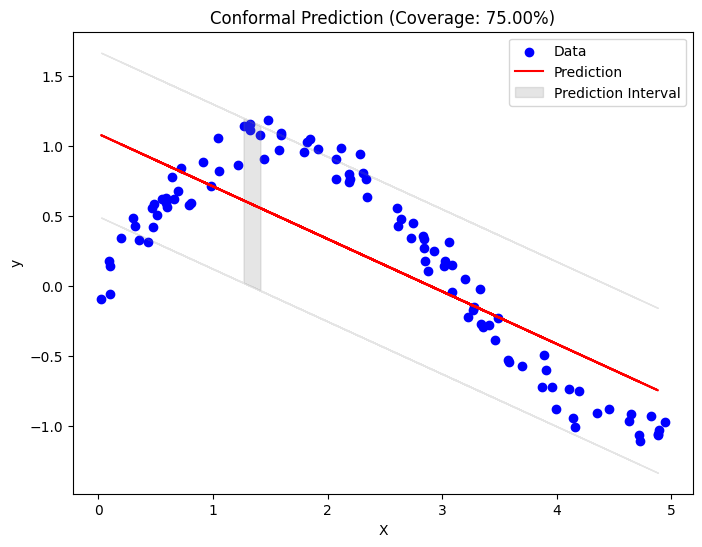

In [10]:
# 9. Visualize Results
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X_test, y_pred, color='red', label='Prediction')
plt.fill_between(X_test.flatten(),
                 [interval[0] for interval in prediction_intervals],
                 [interval[1] for interval in prediction_intervals],
                 color='gray', alpha=0.2, label='Prediction Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title(f'Conformal Prediction (Coverage: {coverage * 100:.2f}%)')
plt.show()


Finally, we visualize the results.  The plot shows the original data, the model's predictions, and the prediction intervals.  Visualizing the results helps to understand how conformal prediction quantifies the uncertainty of the predictions.
